In [1]:
import pandas as pd
import csv

# Define the target products specifically listed in the project doc
target_products = [
    'Credit card', 
    'Credit card or prepaid card', 
    'Checking or savings account', 
    'Savings account',
    'Student loan',
    'Vehicle loan or lease',
    'Payday loan, title loan, or personal loan',
    'Money transfer, virtual currency, or money service'
]

# We use quoting=csv.QUOTE_NONE to prevent the "EOF inside string" error
# We use on_bad_lines='skip' to bypass any corrupted rows
chunk_size = 100000
filtered_chunks = []

print("Starting safe, chunked processing...")

try:
    for chunk in pd.read_csv('../data/raw/complaints.csv', 
                             usecols=['Product', 'Consumer complaint narrative'], 
                             chunksize=chunk_size, 
                             on_bad_lines='skip',
                             quoting=csv.QUOTE_NONE,
                             encoding='utf-8',
                             low_memory=False):
        
        # Keep only the rows that have a narrative AND match our products
        valid_chunk = chunk[
            (chunk['Product'].isin(target_products)) & 
            (chunk['Consumer complaint narrative'].notna())
        ]
        
        filtered_chunks.append(valid_chunk)
        print(f"Processed a chunk... current total filtered: {sum(len(c) for c in filtered_chunks)}")

    # Combine everything
    df_all_filtered = pd.concat(filtered_chunks, ignore_index=True)
    print("\nSUCCESS!")
    print(f"Total relevant complaints found: {len(df_all_filtered)}")
    print("Products found:", df_all_filtered['Product'].unique())

except Exception as e:
    print(f"An error occurred: {e}")

Starting safe, chunked processing...
Processed a chunk... current total filtered: 577
Processed a chunk... current total filtered: 1246
Processed a chunk... current total filtered: 1880
Processed a chunk... current total filtered: 2718
Processed a chunk... current total filtered: 3525
Processed a chunk... current total filtered: 4628
Processed a chunk... current total filtered: 5685
Processed a chunk... current total filtered: 6583
Processed a chunk... current total filtered: 7674
Processed a chunk... current total filtered: 9441
Processed a chunk... current total filtered: 11153
Processed a chunk... current total filtered: 13125
Processed a chunk... current total filtered: 14439
Processed a chunk... current total filtered: 15974
Processed a chunk... current total filtered: 17716
Processed a chunk... current total filtered: 19431
Processed a chunk... current total filtered: 20802
Processed a chunk... current total filtered: 21716
Processed a chunk... current total filtered: 22602
Proce

KeyboardInterrupt: 

In [ ]:
# Define the mapping to CrediTrust categories
mapping = {
    'Credit card': 'Credit Card',
    'Credit card or prepaid card': 'Credit Card',
    'Checking or savings account': 'Savings Account',
    'Savings account': 'Savings Account',
    'Payday loan, title loan, or personal loan': 'Personal Loan',
    'Money transfer, virtual currency, or money service': 'Money Transfer'
}

# Apply mapping
df_all_filtered['Category'] = df_all_filtered['Product'].map(mapping)

# Drop the ones that didn't map (like Student Loans or Vehicle Loans) 
# to keep the data strictly relevant to CrediTrust's 4 products.
df_final = df_all_filtered.dropna(subset=['Category']).copy()

# Check the distribution
print("Count of complaints per business category:")
print(df_final['Category'].value_counts())

Count of complaints per business category:
Category
Credit Card        83000
Savings Account    68713
Name: count, dtype: int64


In [ ]:
# Look for anything containing "Loan" or "Transfer" in the products we already caught
missing_search = df_all_filtered[df_all_filtered['Product'].str.contains('Loan|Transfer|Money', case=False, na=False)]
print("Potential matches for missing categories:")
print(missing_search['Product'].unique())

Potential matches for missing categories:
['Vehicle loan or lease' 'Student loan']


In [ ]:
# We will read just the 'Product' column of the first 1,000,000 rows 
# to find the exact spelling for our missing categories.
sample_products = pd.read_csv('../data/raw/complaints.csv', 
                               usecols=['Product'], 
                               nrows=1000000)

print("Unique products in the first 1M rows:")
print(sample_products['Product'].unique())

Unique products in the first 1M rows:
['Credit reporting or other personal consumer reports' 'Debt collection'
 'Credit card' 'Checking or savings account'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Debt or credit management' 'Mortgage'
 'Payday loan, title loan, personal loan, or advance loan' 'Prepaid card'
 'Student loan' 'Credit reporting'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit card or prepaid card' 'Payday loan, title loan, or personal loan'
 'Bank account or service' 'Money transfers' 'Consumer Loan' 'Payday loan'
 'Other financial service']


In [ ]:
# 1. Define the exact categories based on your output
mapping = {
    # Credit Cards
    'Credit card': 'Credit Card',
    'Credit card or prepaid card': 'Credit Card',
    'Prepaid card': 'Credit Card',
    
    # Savings Accounts
    'Checking or savings account': 'Savings Account',
    'Bank account or service': 'Savings Account',
    'Savings account': 'Savings Account',
    
    # Personal Loans
    'Payday loan, title loan, personal loan, or advance loan': 'Personal Loan',
    'Payday loan, title loan, or personal loan': 'Personal Loan',
    'Consumer Loan': 'Personal Loan',
    'Payday loan': 'Personal Loan',
    
    # Money Transfers
    'Money transfer, virtual currency, or money service': 'Money Transfer',
    'Money transfers': 'Money Transfer'
}

# 2. Re-filter the dataframe using these specific keys
# We use the list of keys from our mapping dictionary
target_product_names = list(mapping.keys())

# Let's filter df_all_filtered (the one from your previous step)
df_final = df_all_filtered[df_all_filtered['Product'].isin(target_product_names)].copy()

# 3. Apply the mapping to create a clean 'Category' column
df_final['Category'] = df_final['Product'].map(mapping)

# 4. Final Verification
print("Final Count of complaints per CrediTrust category:")
print(df_final['Category'].value_counts())
print("-" * 30)
print(f"Total records ready for EDA: {len(df_final)}")

Final Count of complaints per CrediTrust category:
Category
Credit Card        83000
Savings Account    68713
Name: count, dtype: int64
------------------------------
Total records ready for EDA: 151713


In [ ]:
import pandas as pd
import csv

# Same mapping as before
final_target_map = {
    'Credit card': 'Credit Card',
    'Credit card or prepaid card': 'Credit Card',
    'Prepaid card': 'Credit Card',
    'Checking or savings account': 'Savings Account',
    'Bank account or service': 'Savings Account',
    'Savings account': 'Savings Account',
    'Payday loan, title loan, personal loan, or advance loan': 'Personal Loan',
    'Payday loan, title loan, or personal loan': 'Personal Loan',
    'Consumer Loan': 'Personal Loan',
    'Payday loan': 'Personal Loan',
    'Money transfer, virtual currency, or money service': 'Money Transfer',
    'Money transfers': 'Money Transfer'
}

target_names = list(final_target_map.keys())
chunk_size = 100000 
all_relevant_chunks = []

print("Starting ROBUST extraction (Engine: Python)... this may take a few minutes but won't crash.")

try:
    # We switch to engine='python' to avoid the Buffer Overflow
    for chunk in pd.read_csv('../data/raw/complaints.csv', 
                             usecols=['Product', 'Consumer complaint narrative'], 
                             chunksize=chunk_size, 
                             on_bad_lines='skip',
                             quoting=csv.QUOTE_NONE,
                             encoding='utf-8',
                             engine='python', 
                             sep=','):
        
        # Filter and clean
        valid_chunk = chunk[
            (chunk['Product'].isin(target_names)) & 
            (chunk['Consumer complaint narrative'].notna())
        ].copy()
        
        all_relevant_chunks.append(valid_chunk)
        print(f"Collected {sum(len(c) for c in all_relevant_chunks)} rows so far...")

    # Combine everything
    df_master = pd.concat(all_relevant_chunks, ignore_index=True)
    df_master['Category'] = df_master['Product'].map(final_target_map)

    print("\n--- FINAL SUCCESS ---")
    print(df_master['Category'].value_counts())
    print(f"\nTotal records: {len(df_master)}")

except Exception as e:
    print(f"Detailed Error: {e}")

Starting ROBUST extraction (Engine: Python)... this may take a few minutes but won't crash.
Collected 474 rows so far...
Collected 1073 rows so far...
Collected 1608 rows so far...
Collected 2247 rows so far...
Collected 2781 rows so far...
Collected 3492 rows so far...
Collected 4283 rows so far...
Collected 4966 rows so far...
Collected 5638 rows so far...
Collected 6376 rows so far...
Collected 7409 rows so far...
Collected 8577 rows so far...
Collected 9760 rows so far...
Collected 11259 rows so far...
Collected 12117 rows so far...
Collected 13153 rows so far...
Collected 14177 rows so far...
Collected 15337 rows so far...
Collected 16479 rows so far...
Collected 17394 rows so far...
Collected 18024 rows so far...
Collected 18604 rows so far...
Collected 19173 rows so far...
Collected 19748 rows so far...
Collected 20286 rows so far...
Collected 21067 rows so far...
Collected 22057 rows so far...
Collected 23031 rows so far...
Collected 24328 rows so far...
Collected 25792 rows so

C:\Users\Mer\AppData\Local\Temp\ipykernel_8392\1795699402.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


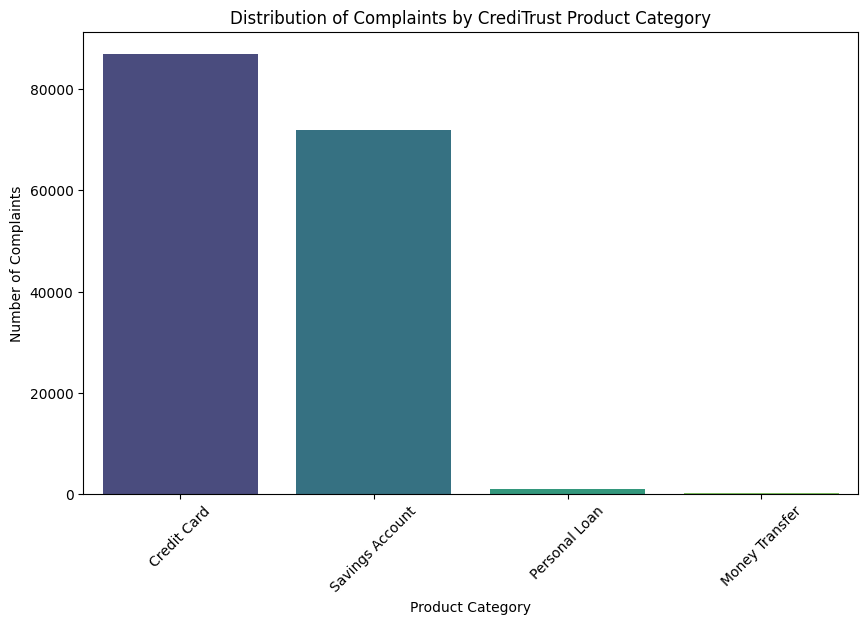

Total records analyzed: 160064
Complaints WITH narratives: 160064
Complaints WITHOUT narratives: 0

Exact counts per category:
Category
Credit Card        87029
Savings Account    71996
Personal Loan        907
Money Transfer       132
Name: count, dtype: int64


In [ ]:
# --- TASK 1: EDA - Product Distribution and Narrative Presence ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Analyze the distribution of complaints across our mapped Categories
plt.figure(figsize=(10, 6))
category_counts = df_master['Category'].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')

plt.title('Distribution of Complaints by CrediTrust Product Category')
plt.xlabel('Product Category')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()

# 2. Identify the number of complaints with and without narratives
total_rows = len(df_master)
missing_narratives = df_master['Consumer complaint narrative'].isna().sum()
present_narratives = total_rows - missing_narratives

print(f"Total records analyzed: {total_rows}")
print(f"Complaints WITH narratives: {present_narratives}")
print(f"Complaints WITHOUT narratives: {missing_narratives}")

# 3. Print the exact counts for your report
print("\nExact counts per category:")
print(category_counts)

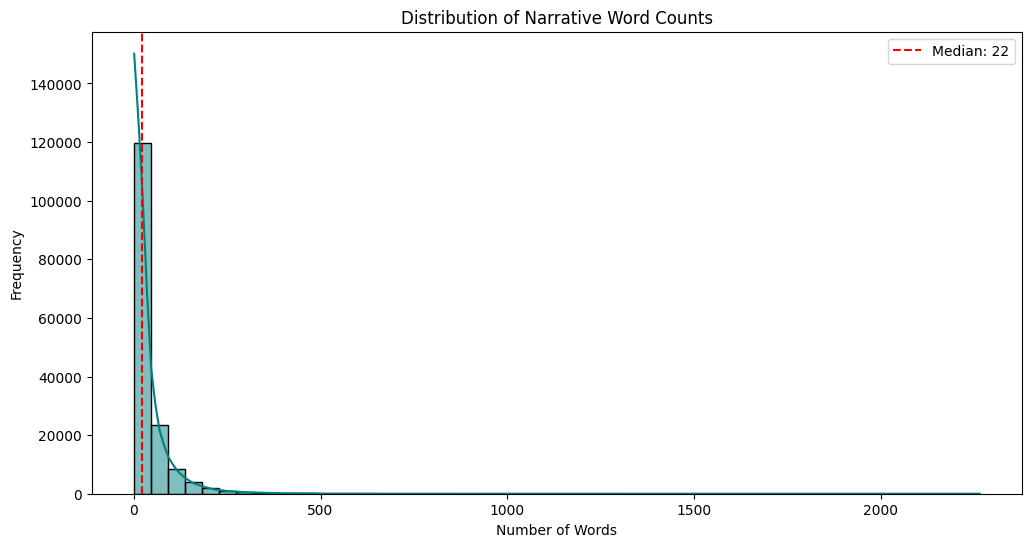

Narrative Length Statistics:
count    160064.000000
mean         38.729958
std          56.992626
min           1.000000
25%           6.000000
50%          22.000000
75%          47.000000
max        2265.000000
Name: word_count, dtype: float64

--- OUTLIER CHECK ---
Shortest narrative: 1 words
Longest narrative: 2265 words


In [ ]:
# --- TASK 1: EDA - Narrative Length Analysis (Word Counts) ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate word counts for each narrative
df_master['word_count'] = df_master['Consumer complaint narrative'].apply(lambda x: len(str(x).split()))

# 2. Visualize the distribution of word counts
plt.figure(figsize=(12, 6))
sns.histplot(df_master['word_count'], bins=50, kde=True, color='teal')
plt.title('Distribution of Narrative Word Counts')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(df_master['word_count'].median(), color='red', linestyle='--', label=f'Median: {df_master["word_count"].median():.0f}')
plt.legend()
plt.show()

# 3. Identify extreme lengths
print("Narrative Length Statistics:")
print(df_master['word_count'].describe())

print("\n--- OUTLIER CHECK ---")
print(f"Shortest narrative: {df_master['word_count'].min()} words")
print(f"Longest narrative: {df_master['word_count'].max()} words")

In [ ]:
# --- TASK 1: PREPROCESSING - Cleaning, Filtering, and Saving ---

import re

def clean_complaint(text):
    # 1. Lowercasing
    text = str(text).lower()
    
    # 2. Removing boilerplate and "XXXX" masks
    # We remove "xxxx" because it's used for redacted personal info
    text = re.sub(r'x{2,}', '', text) 
    
    # Remove common boilerplate phrases
    boilerplate = [
        r"i am writing to file a complaint",
        r"to whom it may concern",
        r"please see attached"
    ]
    for pattern in boilerplate:
        text = re.sub(pattern, "", text)
    
    # 3. Removing special characters and extra whitespace
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply cleaning
print("Cleaning text narratives...")
df_master['cleaned_narrative'] = df_master['Consumer complaint narrative'].apply(clean_complaint)

# Filter out "very short" narratives that add no value (e.g., less than 5 words)
print("Filtering out narratives shorter than 5 words...")
df_final_cleaned = df_master[df_master['cleaned_narrative'].str.split().str.len() >= 5].copy()

# Final check of counts
print(f"\nFinal record count after cleaning: {len(df_final_cleaned)}")
print(df_final_cleaned['Category'].value_counts())

# SAVE THE DATASET as required by the instructions
df_final_cleaned.to_csv('../data/filtered_complaints.csv', index=False)
print("\nSUCCESS: Dataset saved to data/filtered_complaints.csv")

Cleaning text narratives...
Filtering out narratives shorter than 5 words...

Final record count after cleaning: 124037
Category
Credit Card        63295
Savings Account    59815
Personal Loan        811
Money Transfer       116
Name: count, dtype: int64

SUCCESS: Dataset saved to data/filtered_complaints.csv
